We will predict the annual medical expenditure for new customers, using information such as their age, sex, BMI, children, smoking habits and region of residence.



In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

In [4]:
med_df=pd.read_csv("medical-charges.csv")

In [5]:
med_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [9]:
med_df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


The "charges" column seems to be significantly skewed(right skewed) however, as the median (50 percentile) is much lower than the mean.

Check for null values.

In [10]:
med_df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [11]:
med_df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

Let's explore the data by visualizing the distribution of values in some columns of the dataset, and the relationships between "charges" and other columns.

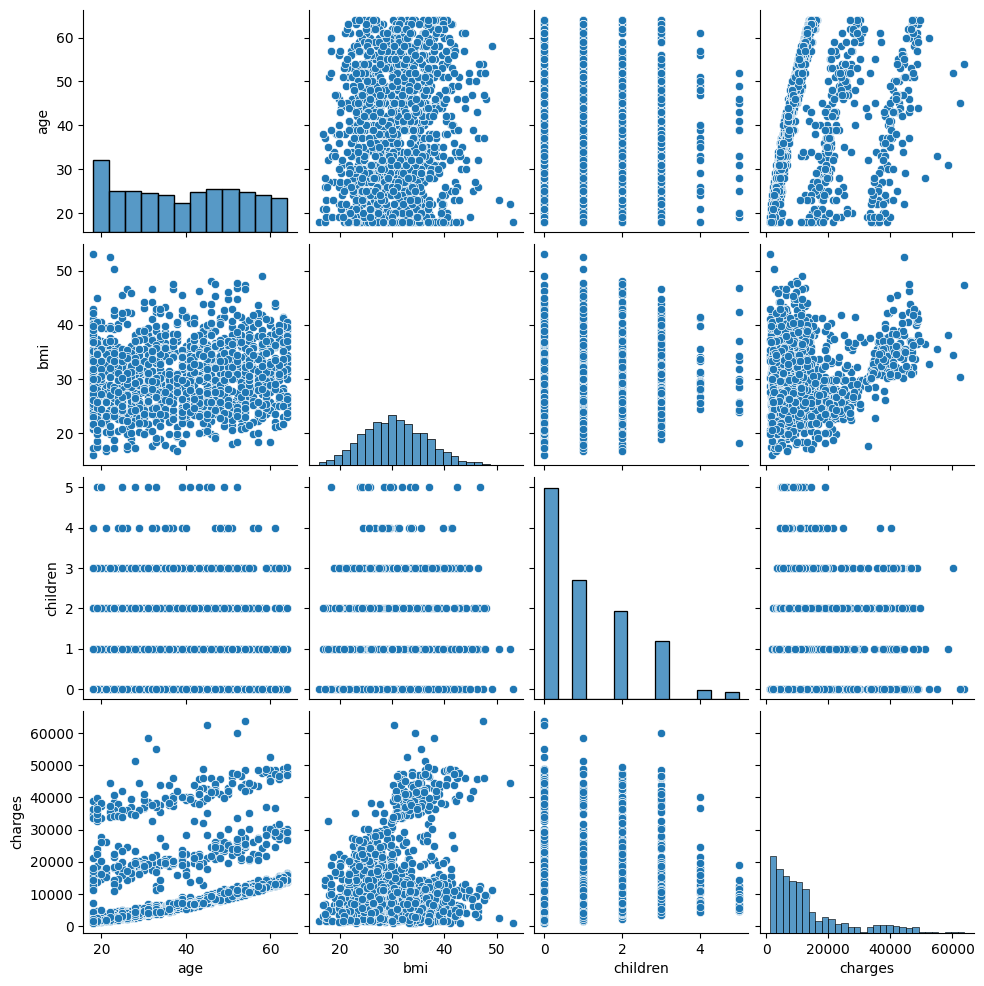

In [12]:
sns.pairplot(med_df)

<Axes: xlabel='charges', ylabel='Count'>

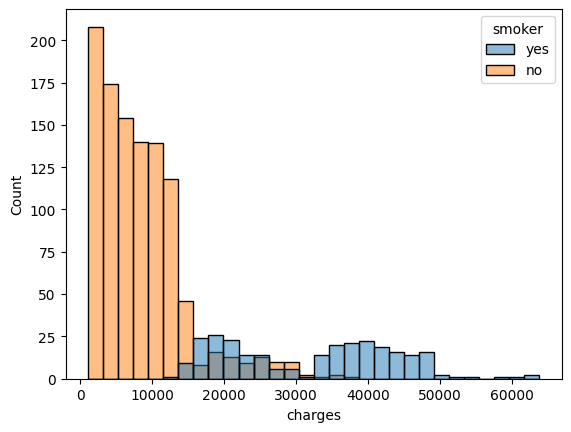

In [38]:
#Check out the distribution of the column we want to predict
sns.histplot(data=med_df, x="charges", hue="smoker")

We can make the following observations from the above graph:

For most customers, the annual medical charges are under \$10,000. Only a small fraction of customer have higher medical expenses, possibly due to accidents, major illnesses and genetic diseases. 

There is a significant difference in medical expenses between smokers and non-smokers. While the median for non-smokers is \
7300 the median for smokers is close to 35,000.

In [39]:
med_df.smoker.value_counts()

smoker
no     1064
yes     274
Name: count, dtype: int64

<Axes: xlabel='age', ylabel='charges'>

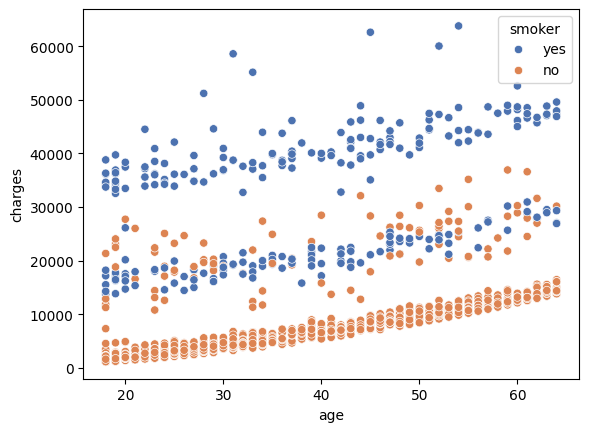

In [45]:
sns.scatterplot(data=med_df, x="age", y="charges",hue="smoker", palette="deep")

The general trend seems to be that medical charges increase with age, as we might expect. However, there is significant variation at every age, and it's clear that age alone cannot be used to accurately determine medical charges.

We can see three "clusters" of points, each of which seems to form a line with an increasing slope:

The first and the largest cluster consists primary of presumably "healthy non-smokers" who have relatively low medical charges compared to others

The second cluster contains a mix of smokers and non-smokers. It's possible that these are actually two distinct but overlapping clusters: "non-smokers with medical issues" and "smokers without major medical issues".

The final cluster consists exclusively of smokers, presumably smokers with major medical issues that are possibly related to or worsened by smoking.

<Axes: xlabel='age', ylabel='charges'>

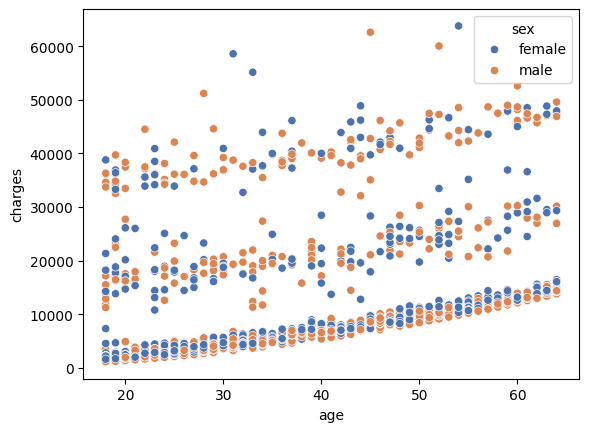

In [65]:
sns.scatterplot(data=med_df, x="age", y="charges",hue="sex", palette="deep")

<Axes: xlabel='age', ylabel='charges'>

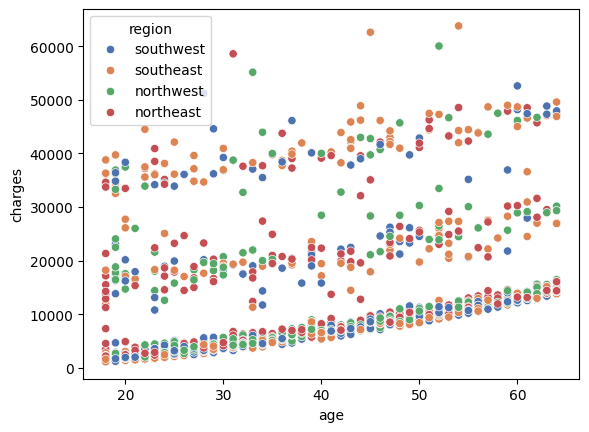

In [66]:
sns.scatterplot(data=med_df, x="age", y="charges",hue="region", palette="deep")

In [54]:
smoker_values={'no':0,'yes':1}
med_df['smoker_numeric']=med_df.smoker.map(smoker_values)

In [56]:
med_df.head()

,age,sex,bmi,children,smoker,region,charges,1,0,smoker_numeric
0,19,female,27.900,0,yes,southwest,16884.92400,1,0,1
1,18,male,33.770,1,no,southeast,1725.55230,1,0,0
2,28,male,33.000,3,no,southeast,4449.46200,1,0,0
3,33,male,22.705,0,no,northwest,21984.47061,1,0,0
4,32,male,28.880,0,no,northwest,3866.85520,1,0,0


In [67]:
# med_df.charges.corr(med_df.age)
medical_df=med_df[['age', 'bmi', 'children', 'charges']]

In [68]:
medical_df.corr()

,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


<Axes: >

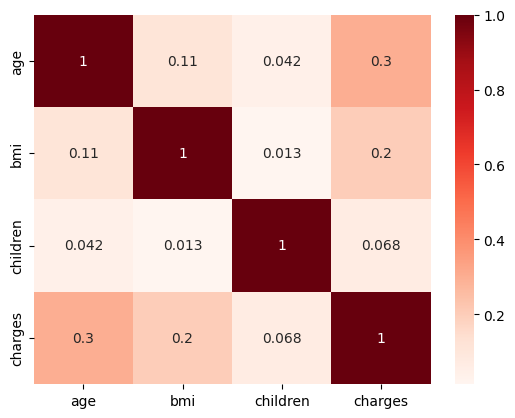

In [70]:
sns.heatmap(medical_df.corr(), cmap='Reds', annot=True)